# Convolution Neural Network in PyTorch

## Classification task

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt

import os
import copy
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision
from torchvision import transforms, datasets
import torchvision.transforms as T

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from tqdm.notebook import tqdm, trange

import pandas as pd
try:  
    from torchsummary import summary
except:
    !pip install -U torchsummary
finally:    
    from torchsummary import summary

In [3]:
def torch_stats(): 
    torch_version = ".".join(torch.__version__.split(".")[:2])
    print('torch version:',torch_version)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)
    dtype = torch.float32
    
    if device.type == 'cuda':
        cuda_version  = torch.__version__.split("+")[-1]
        print("cuda: ", cuda_version)
        
        torch.set_default_tensor_type(torch.cuda.FloatTensor)
        print('Cuda is available:',torch.cuda.is_available())

        n_devices = torch.cuda.device_count()
        print('number of devices: %d'%(n_devices))

        for cnt_device in range(n_devices):
            print(torch.cuda.get_device_name(cnt_device))
            print('Memory Usage:')
            print('Allocated:', round(torch.cuda.memory_allocated(cnt_device)/1024**3,1), 'GB')
            print('Cached:   ', round(torch.cuda.memory_reserved(cnt_device)/1024**3,1), 'GB')


    torch.set_default_dtype(dtype) # float32
    print('default data type:',dtype)
    
    num_workers=os.cpu_count()
    print ('available number of workers:',num_workers)
    
    return device, dtype, num_workers
#-------------------------------
def torch_seed(seed = 42, deterministic = True):
    random.seed(seed) # random and transforms
    np.random.seed(seed) #numpy
    torch.manual_seed(seed) #cpu
    torch.cuda.manual_seed(seed) #gpu
    torch.backends.cudnn.deterministic=deterministic #cudnn  

In [4]:
device, dtype, num_workers = torch_stats()
torch_seed(seed = 42, deterministic = True)

torch version: 1.11
Using device: cuda
cuda:  cu113
Cuda is available: True
number of devices: 1
Tesla K80
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
default data type: torch.float32
available number of workers: 2


For the first let;s considering the dataset <code>Cifar10</code> - it is the classical for our task dataset with 10 classes, each of the images is <code>32x32x3</code> size.
The example of image :

![](https://debuggercafe.com/wp-content/uploads/2019/10/cifar10_plot.png)

The dataset can be downloaded from <code>torchvision.datasets</code>. We transform the data to the generots using <code>torch.utils.data.DataLoader</code>

In [35]:
MEAN = np.asarray([0.485, 0.456, 0.406]) 
STD  = np.asarray([0.229, 0.224, 0.225])

train_transforms = transforms.Compose([
                            transforms.RandomRotation(5),
                            transforms.Resize(36),
                            transforms.RandomCrop(32, padding=2),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=MEAN, std=STD)
                                      ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=MEAN, std=STD)
                                     ])

trainset = torchvision.datasets.CIFAR10(root      = './data', 
                                        train     = True,
                                        download  = True, 
                                        transform = train_transforms)


testset = torchvision.datasets.CIFAR10(root      = './data', 
                                       train     = False,
                                       download  = True, 
                                       transform = test_transforms)


names_classes = trainset.classes
#('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print('classes:',names_classes)

Files already downloaded and verified
Files already downloaded and verified
classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In addiiton we can divide train data into train and test parts.

In [36]:
VALID_RATIO = 0.9

n_train_examples = int(len(trainset) * VALID_RATIO)

n_valid_examples = len(trainset) - n_train_examples

if torch.cuda.is_available():
    kwarg = {'generator':torch.Generator(device='cuda')}
else:
     kwarg = {'num_workers':num_workers}

trainset, validset = data.random_split(trainset,
                                           [n_train_examples, n_valid_examples], **kwarg)

validset = copy.deepcopy(validset)
validset.dataset.transform = test_transforms

In [37]:
print(f'Number of training examples: {len(trainset)}')
print(f'Number of validation examples: {len(validset)}')
print(f'Number of testing examples: {len(testset)}')

Number of training examples: 45000
Number of validation examples: 5000
Number of testing examples: 10000


After datasets initialization we must crate dataloaders (generators of batches).

In [38]:
BATCH_SIZE = 64

if torch.cuda.is_available():
    kwarg = {'generator':torch.Generator(device='cuda')}
else:
     kwarg = {'num_workers':0}

trainloader = data.DataLoader(trainset,shuffle=True,batch_size=BATCH_SIZE, **kwarg)

validloader = data.DataLoader(validset,batch_size=BATCH_SIZE, **kwarg)

testloader  = data.DataLoader(testset,batch_size=BATCH_SIZE, **kwarg)

So we can visualize the dataset
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(274, 274, 3)


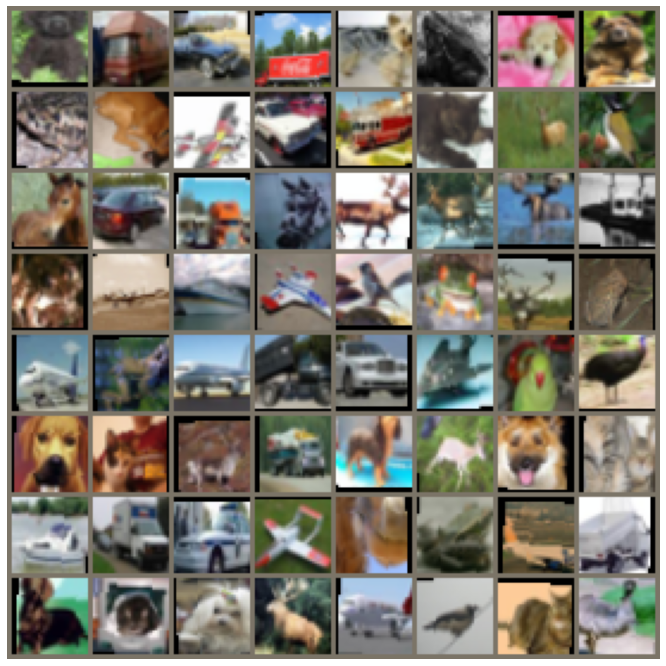

first raw classes   dog truck automobile truck   dog  frog   dog   dog
torch.Size([64, 3, 32, 32])


In [47]:
def imshow(images, mean=MEAN, std=STD):
    
    img = torchvision.utils.make_grid(images)
    
    
    img = img.data.cpu().numpy().transpose((1,2,0))
    print(img.shape)
    img = (img * std + mean) # unnormalize    
 
    
    plt.figure(figsize=(16,12))
    plt.imshow(img); plt.axis('off'); plt.show()


images, labels = next(iter(trainloader))

imshow(images)

print('first raw classes',' '.join('%5s' % names_classes[labels[j]] for j in range(BATCH_SIZE//8)))

print(images.shape)

Now let's describe the model. For that  we will use classical `LeNet` model. 
![](https://miro.medium.com/max/3600/1*-NnRGtEsiLHfNnUCSXoa-Q.png)

The network consits in: <ul>
<li> input image 32х32 ( for us 3х32х32),
<li> two conv layers, 
<li> each conv layer has pooling after,
<li> flat - vectorization layer,
<li> two full-connected layers,
<li> output layer - softmax classification with 10 outputs.
</ul>
The features of architecture:<ul>
<li> valid convolution (without padding, with size reduction)$^*$;
<li> each conv kernel has size 5х5 (kernel size = 5);
<li> maxpooling with stride 2 and tiles 2х2;
<li> first layer output has 6 feature maps with size 14х14 (after pooling);
<li> second conv layer 16 feature maps with size 5х5 (after pooling);
<li> flat layer take 16 maps 5х5 and give $1х16*5*5$ (1х400);
<li> first full-connected layer give 120 outputs;
<li> second full-connected layer give 84 outputs.
</ul>
   For studying aim let's add dropout and batchnorm also.   
$^*$the output of conv layer size can be calculated as: W=(W−F+2P)/S+1, where W is input size, F is kernel size, S is stride applied, and P is padding. 
   

In [48]:
class LeNet(nn.Module):
    
    def __init__(self, in_channels, n_classes):
        super().__init__()
        
        self.in_channels = in_channels
        self.n_classes   = n_classes
        
        # convolution
        self.conv1   = nn.Conv2d(in_channels  = self.in_channels, 
                                 out_channels = 6, 
                                 kernel_size  = 5)
                                        

        self.conv2   = nn.Conv2d(in_channels  = 6, 
                                 out_channels = 16,
                                 kernel_size  = 5)
        
        # pooling
        self.pool = nn.AvgPool2d(kernel_size = 2, 
                                 stride      = 2)
        
        # classification
        self.fc1 = nn.Linear(in_features  = 16 * 5 * 5, 
                             out_features = 120)
        
        self.fc2 = nn.Linear(in_features  = 120, 
                             out_features = 84)
        
        self.fc_out = nn.Linear(in_features = 84, 
                                out_features = self.n_classes)

    def flatten(self, x):
        # 16 feature map with size 5 x 5
        return x.view(-1, 16 * 5 * 5) 
    
    def forward(self, x):
        
        # 1-st layer
        x = self.conv1(x)
        x = torch.tanh(x)        
        x = self.pool(x)
        
        #2-nd layer
        x = self.conv2(x)         
        x = torch.tanh(x)        
        x = self.pool(x)

        #flatten
        x = self.flatten(x)
        
        # 1-st fc layer
        x = self.fc1(x)
        x = torch.tanh(x)
        
        # 2-nd fc layer
        x = self.fc2(x)
        x = torch.tanh(x)
        
        # output layer
        x = self.fc_out(x)
        
        return x#torch.softmax(x, dim=1)

Actually we could describe the model with container sequential, like it is shown below, but it could be problematic in farther.
```python
model = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5, padding=2), 
            nn.Tanh(),
            nn.AvPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5), 
            nn.Tanh(),
            nn.AvPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(16 * 5 * 5, 120),
            nn.Tanh(),
            nn.Linear(120, 84), 
            nn.Tanh(),
            nn.Linear(84, 10)
            )
```

Let's define setting of training.

For determin accuacy during the training and evaluation stages we can create the following function.

In [50]:
def accuracy(y_pred, y):
    cls_pred = y_pred.argmax(1, keepdim=True)    
    correct_cls = cls_pred.eq(y.view_as(cls_pred)).sum()
    acc = correct_cls.float() / y.shape[0]
    return acc

Now we can describe the train step (epoch).

In [51]:
def train(model, dataloader, optimizer, criterion, metric,  device):

    epoch_loss = 0
    epoch_acc  = 0

    model.train()

    for (x, y) in tqdm(dataloader, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model.forward(x)

        loss = criterion(y_pred, y)
        acc  = metric( y_pred, y)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc  += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

Similary to above one we can describe the evaluate function.

In [52]:
def evaluate(model, dataloader, criterion, metric, device):

    epoch_loss = 0
    epoch_acc  = 0

    model.eval()

    with torch.no_grad():
        
        for (x, y) in tqdm(dataloader, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred = model.forward(x)

            loss = criterion(y_pred, y)
            acc  = metric( y_pred, y)

            epoch_loss += loss.item()
            epoch_acc  += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

In addition we will need function to estiamte epoch time.

In [53]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Now we can describe setting for our model

In [54]:
LR = 0.003
model     = LeNet(3,10)
criterion = nn.CrossEntropyLoss()
metric    = accuracy
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9)

model     = model.to(device)
criterion = criterion.to(device)


now we can see the summary

In [55]:
for name, param in model.named_parameters():
    print(name, '\t structure =',list(param.size()))

conv1.weight 	 structure = [6, 3, 5, 5]
conv1.bias 	 structure = [6]
conv2.weight 	 structure = [16, 6, 5, 5]
conv2.bias 	 structure = [16]
fc1.weight 	 structure = [120, 400]
fc1.bias 	 structure = [120]
fc2.weight 	 structure = [84, 120]
fc2.bias 	 structure = [84]
fc_out.weight 	 structure = [10, 84]
fc_out.bias 	 structure = [10]


In [ ]:
for name, child in model.named_children():
    print(name, '\t structure =',list(child.size()))

In [56]:
summary(model,input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         AvgPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         AvgPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


In [59]:
X = torch.randn(1, 3, 32, 32) # Batch Size x Channels x Wide x Height
out = model(X)
print(out.data.cpu().numpy(), '\n max position (Class index):', out.argmax().item())

[[-0.04781573 -0.06848599  0.05672119 -0.02048448 -0.15619466 -0.03430833
   0.00852297 -0.12003808 -0.00372491 -0.01451189]] 
 max position (Class index): 2


Let's start traing, as it shown below.Our fitting algorithm includes training and evaluation in each epoch, and also routine of searching the best epoch by accuracy on validation data.

In [60]:
EPOCHS = 20

train_loss = torch.zeros(EPOCHS)
valid_loss = torch.zeros(EPOCHS)
train_acc  = torch.zeros(EPOCHS)
valid_acc  = torch.zeros(EPOCHS)

best_valid_loss = float('inf')
best_epoch = 0

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()
    
    train_loss[epoch], train_acc[epoch] = train(model, 
                                                trainloader, 
                                                optimizer, 
                                                criterion,
                                                metric,
                                                device)
    
    valid_loss[epoch], valid_acc[epoch] = evaluate(model, 
                                                   validloader, 
                                                   criterion,
                                                   metric,
                                                   device)

    if valid_loss[epoch] < best_valid_loss:
        best_valid_loss = valid_loss[epoch]
        best_epoch = epoch
        torch.save(model.state_dict(), 'lenet_best_model.pt')

    epoch_mins, epoch_secs = epoch_time(start_time, time.monotonic())
    if epoch%2 == 1:    # print every 2 epochs:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss[epoch]:.3f} | Train Acc: {train_acc[epoch]*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss[epoch]:.3f} |  Val. Acc: {valid_acc[epoch]*100:.2f}%')

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 47s
	Train Loss: 1.807 | Train Acc: 34.69%
	 Val. Loss: 1.684 |  Val. Acc: 40.64%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 47s
	Train Loss: 1.623 | Train Acc: 41.07%
	 Val. Loss: 1.497 |  Val. Acc: 46.70%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 47s
	Train Loss: 1.541 | Train Acc: 44.32%
	 Val. Loss: 1.434 |  Val. Acc: 48.83%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 47s
	Train Loss: 1.482 | Train Acc: 46.42%
	 Val. Loss: 1.382 |  Val. Acc: 50.20%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 47s
	Train Loss: 1.439 | Train Acc: 48.28%
	 Val. Loss: 1.336 |  Val. Acc: 51.60%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 47s
	Train Loss: 1.401 | Train Acc: 49.38%
	 Val. Loss: 1.303 |  Val. Acc: 52.51%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 46s
	Train Loss: 1.375 | Train Acc: 50.56%
	 Val. Loss: 1.304 |  Val. Acc: 53.24%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 47s
	Train Loss: 1.347 | Train Acc: 51.49%
	 Val. Loss: 1.257 |  Val. Acc: 54.61%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 47s
	Train Loss: 1.319 | Train Acc: 52.85%
	 Val. Loss: 1.246 |  Val. Acc: 55.16%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 47s
	Train Loss: 1.302 | Train Acc: 53.04%
	 Val. Loss: 1.218 |  Val. Acc: 56.45%


We can visualize results of training by the following routine.

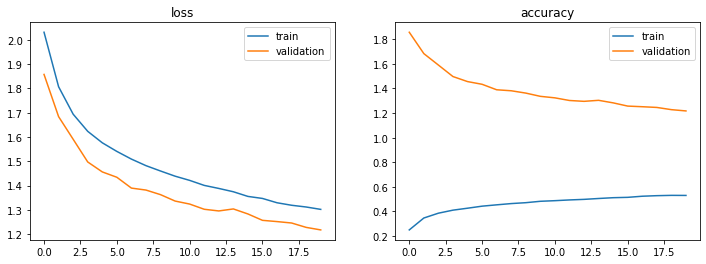

In [63]:
def plot_results(train_loss, valid_loss, train_acc, valid_acc ):
    fig,axs = plt.subplots(1,2,figsize = (12,4))
    axs[0].plot(train_loss.cpu().numpy(), label = 'train')
    axs[0].plot(valid_loss.cpu().numpy(), label = 'validation')
    axs[0].set_title('loss')
    axs[0].legend()
    axs[1].plot(train_acc.cpu().numpy(), label = 'train')
    axs[1].plot(valid_acc.cpu().numpy(), label = 'validation')
    axs[1].set_title('accuracy')
    axs[1].legend()
    plt.show()

plot_results(train_loss, valid_loss, train_acc, valid_loss )

save results

In [65]:
PATH = './cifar_net.pth'
torch.save(model.state_dict(), PATH)

download results

In [66]:
model = LeNet(3,10)
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Test results for best epoch

In [67]:
model.load_state_dict(torch.load('lenet_best_model.pt'))
test_loss, test_acc = evaluate(model, testloader, criterion, metric, device)
print(f'best epoch {best_epoch}: Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

best epoch 19: Test Loss: 1.206 | Test Acc: 57.15%


In [70]:
model.eval()
dataiter = iter(testloader)
images, labels = dataiter.next()
with torch.no_grad():
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
# (outputs)

and learn predictions

In [72]:
_, predicted = torch.max(outputs, 1)
print(predicted)

tensor([3, 1, 8, 1, 6, 6, 1, 6, 5, 1, 0, 9, 3, 7, 1, 8, 5, 7, 8, 6, 7, 0, 0, 9,
        2, 4, 2, 2, 1, 6, 6, 4, 2, 2, 9, 3, 4, 1, 9, 5, 0, 6, 7, 6, 8, 9, 3, 9,
        7, 2, 9, 2, 6, 5, 8, 8, 7, 4, 3, 3, 7, 3, 1, 6])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(274, 274, 3)


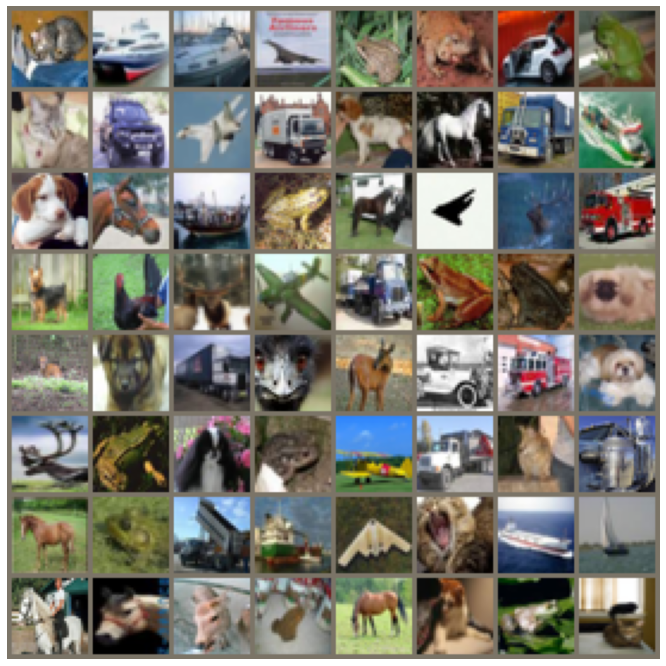

GroundTruth:    cat  ship  ship airplane
Predicted :     cat automobile  ship automobile


In [75]:
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % names_classes[labels[j]] for j in range(4)))
print('Predicted :  ', ' '.join('%5s' % names_classes[predicted[j]] for j in range(4)))

Let's test the accuracy as number of correct prediction to all

In [76]:
n_classes = 10
n_samples = len(testset)

class_correct = torch.zeros(n_classes)
class_total   = torch.zeros(n_classes)

labels   = []
predicts = []

model.eval()

with torch.no_grad():
    
    for x,y in tqdm(testloader):
        x = x.to(device)
        y = y.to('cpu')

        y_pred = model.forward(x).to('cpu')
        
        cls_pred = torch.argmax(y_pred, dim=1)
        
        c = (cls_pred == y).squeeze() # one-hot vector
        
        for i in range(x.shape[0]):
            label = y[i]
            class_correct[label] += c[i].item()
            class_total[label]   += 1
    
        labels.append(y)
        predicts.append(cls_pred)
        
labels   = torch.cat(labels, dim = 0) # make it 1d array
predicts = torch.cat(predicts, dim = 0) # make it 1d array
    
for i in range(n_classes):
    print('Accuracy of %5s : %2d %%' % (
        names_classes[i], 100 * class_correct[i] / class_total[i]))

  0%|          | 0/157 [00:00<?, ?it/s]

Accuracy of airplane : 64 %
Accuracy of automobile : 78 %
Accuracy of  bird : 45 %
Accuracy of   cat : 44 %
Accuracy of  deer : 39 %
Accuracy of   dog : 45 %
Accuracy of  frog : 65 %
Accuracy of horse : 64 %
Accuracy of  ship : 70 %
Accuracy of truck : 54 %


Also you may represent the results as correlation (heat) map

In [77]:
def plot_confusion_matrix(labels, pred_labels, names_classes):
    
    fig, ax = plt.subplots(figsize=(10, 10))
    
    cm = confusion_matrix(np.asarray(labels, dtype=int), 
                          np.asarray(pred_labels, dtype=int) )
    
    cm = ConfusionMatrixDisplay(cm, display_labels=names_classes)
    
    cm.plot(values_format='d', cmap='coolwarm', ax=ax)

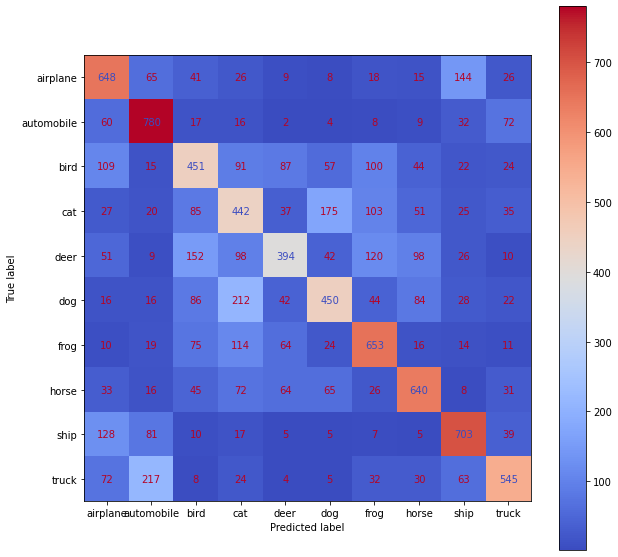

In [78]:
plot_confusion_matrix(labels, predicts, names_classes)

IF you want to store the results you may also use this code

In [79]:
sorted_ids = list(range(1, n_samples + 1)) 

sorted_ids.sort(key=lambda x: str(x))

df = pd.DataFrame({'id': sorted_ids, 'label': predicts})

df['label'] = df['label'].apply(lambda x: names_classes[x])

df.to_csv('submission.csv', index=False)

For some research proposed we can visualize features or weights for each layer, like it is shown below.

In [80]:
def plot_filtered_images(images, filters):

    images = torch.cat([i.unsqueeze(0) for i in images], dim=0).cpu()
    
    print(images.shape)
    
    filters = filters.cpu()

    n_images  = images.shape[0]
    n_filters = filters.shape[0]

    filtered_images = F.conv2d(images, filters)
    
    fig = plt.figure(figsize=(20, 20))

    for i in range(n_images):

        img = images[i].squeeze(0).numpy().transpose((1,2,0))
        
        img = 255*(img - img.min())/(img.max() - img.min())

        ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters))
        
        ax.imshow(img.astype(int), cmap='bone')
        ax.set_title('Original')
        ax.axis('off')

        for j in range(n_filters):
            image = filtered_images[i][j]
            
            image = image.numpy().astype(float)
            
            image = 255*(image - image.min())/(image.max() - image.min())
            
            ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)
            
            ax.imshow(image.astype(int), cmap='bone')
            
            ax.set_title(f'Filter {j+1}')
            ax.axis('off')
    return filtered_images

torch.Size([5, 3, 32, 32])


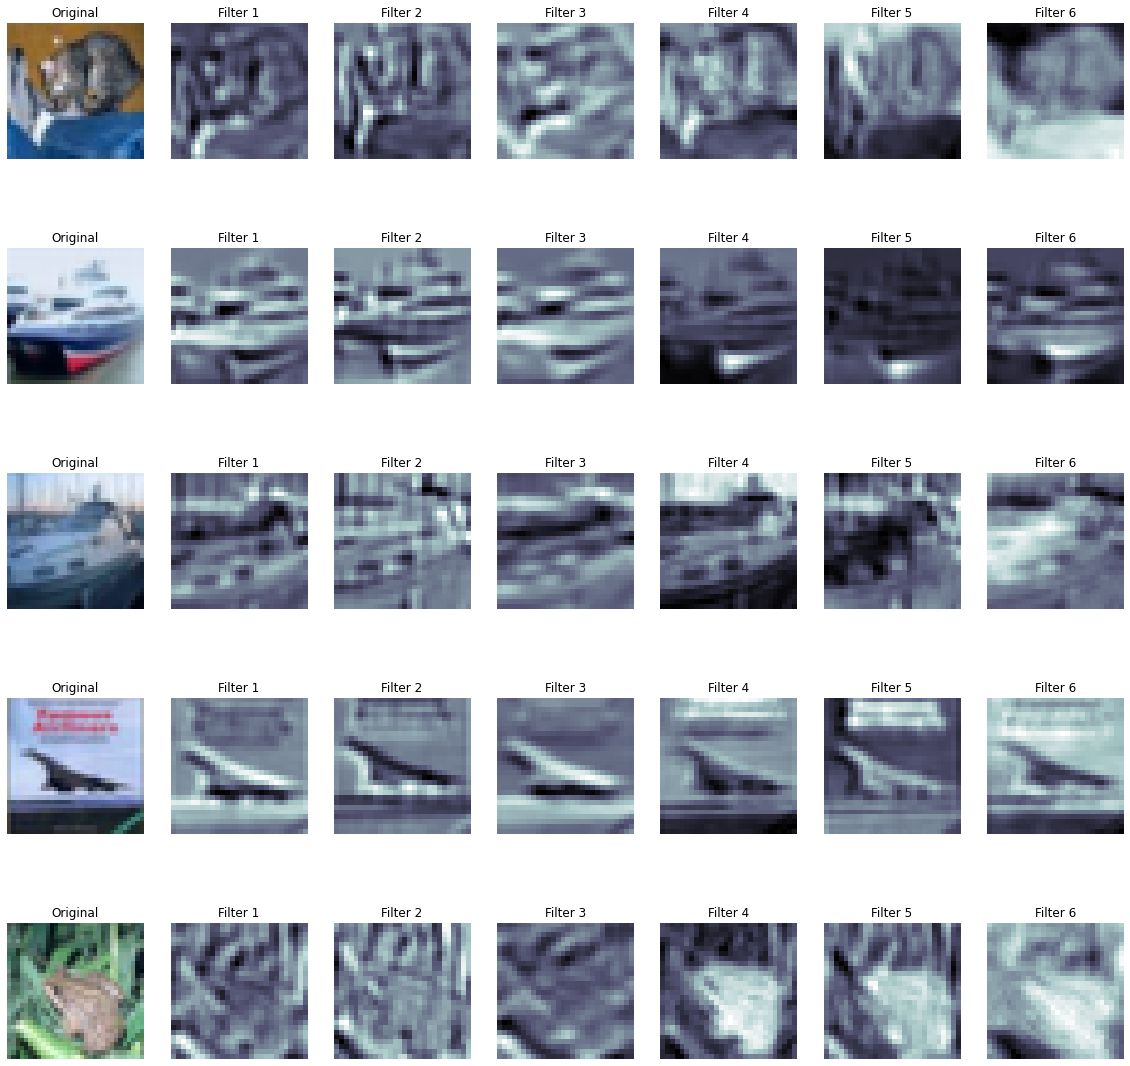

In [81]:
N_IMAGES = 5

images = [image for image, label in [testset[i] for i in range(N_IMAGES)]]

filters = model.conv1.weight.data

filtered_images = plot_filtered_images(images, filters)

and for filters.

In [82]:
def plot_filters(filters):

    filters = filters.cpu()

    n_filters = filters.shape[0]

    fig = plt.figure(figsize=(20, 10))

    for i in range(n_filters):
        filt = filters[i].squeeze(0).numpy().transpose((1,2,0))
        ax = fig.add_subplot(1, n_filters, i+1)
        ax.imshow(filt[:,:,1], cmap='bone')
        ax.axis('off')

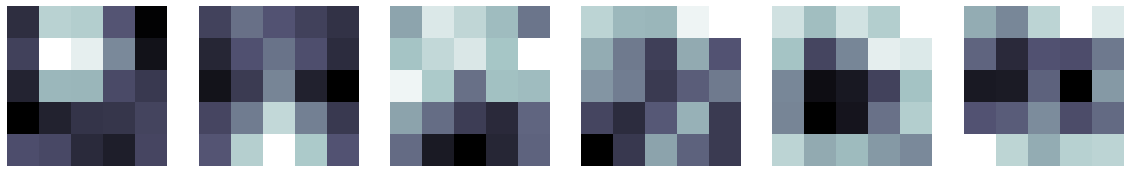

In [83]:
filters = model.conv1.weight.data
plot_filters(filters)

*Exercise 1* <br>
Add the early stop to the fitting by condition: valid loss does not decrease 3 epochs.

*Exercise 2* <br>
 Analyze the results and drop the class with the least accurate, then try training again, what's happen?

! $^$ *Note*: If you do not have GPU and want to seep up your training, you may use Google Colab with GPU runtime. 

For change **runtime** please select **Change runtime type** in the corresponding menu.
<br><u><b><Large>After your experiments please do not forget to return runtime type to None (CPU). Google provides GPU only temporarily.<b><u>

<!-- <img src="https://cdn.analyticsvidhya.com/wp-content/uploads/2020/03/uc14.png" width="500"> -->
<img src="https://course.fast.ai/images/colab/04.png" width="350">

**Network optimization**


Weights initialization

In [101]:
model = LeNet(3,10)
        
def init_weights(m):
    # for differernt types of layers different initialization could be applied
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0.01)
    
    #same as type(m) == nn.Conv2d, but more correct to use isinstance   
    if isinstance(m, nn.Conv2d):  
        torch.nn.init.xavier_uniform_(m.weight)
        torch.nn.init.zeros_(m.bias)   

model.apply(init_weights);

In some cases it more usefull to apply ADAM optimizer instead of using SGD.  And also let's add learning schaduler.

In [102]:
LR = 0.0008
LR_PERIOD = 4
LR_DECAY  = 0.95 

criterion = nn.CrossEntropyLoss()
metric    = accuracy
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

model     = model.to(device)
criterion = criterion.to(device)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                            step_size = LR_PERIOD, 
                                            gamma     = LR_DECAY)

Test it

In [98]:
for name, p in model.named_parameters():    
    if 'bias' in name:
        print(p,'\n')

Parameter containing:
tensor([ 0.6788, -2.2355,  0.4075, -0.7927,  1.0163, -0.9632],
       requires_grad=True) 

Parameter containing:
tensor([ 0.3284, -0.7171,  0.1464, -1.9882, -0.6756,  0.5842,  2.6186, -0.8756,
         1.7797,  1.0050, -0.3259, -1.0521,  0.8604,  2.7938, -0.2482,  1.2287],
       requires_grad=True) 

Parameter containing:
tensor([ 0.0286,  0.1571,  0.6645,  0.9075, -0.0562,  0.0690,  0.1333,  1.1934,
         1.1947, -1.0139,  0.2849, -0.2602, -0.3880,  0.0392,  0.6315, -0.1822,
        -0.5117, -0.1110,  0.7827, -0.8028, -0.2584, -0.7686,  0.1775, -0.2160,
         0.3421,  1.0144, -0.6683,  0.0328,  0.1014,  0.2526,  1.0260, -0.1802,
        -0.0308,  0.0916, -0.7022,  0.2868,  0.0609,  0.2069,  0.0116,  0.0138,
         0.3023,  0.8111,  0.4512, -0.7070, -0.0400,  0.2335,  0.5558,  1.1083,
         0.5008, -1.1135,  0.1552, -0.7168,  0.2700, -0.1228, -0.0040, -0.9077,
         0.1382,  0.7000,  0.3917, -0.3523, -0.4601, -0.1051, -0.5772, -0.3438,
        -0.3

 Now we can look at the weights for one of the layers.

In [103]:
print(model.fc2.weight)

Parameter containing:
tensor([[ 3.7073e-02,  3.2644e-02,  1.4985e-01,  ..., -1.2021e-01,
          1.5636e-01, -1.2410e-01],
        [-1.6438e-01,  1.0916e-01, -8.2617e-02,  ...,  2.0847e-01,
         -3.8142e-02,  9.3620e-02],
        [ 1.4221e-01, -2.5037e-01, -1.2865e-01,  ..., -2.8317e-01,
         -4.6902e-02,  1.8686e-02],
        ...,
        [ 3.0893e-02,  9.2695e-02, -8.1392e-02,  ...,  4.3908e-03,
          1.6957e-01, -2.6562e-04],
        [-1.5880e-01,  6.4327e-02,  2.4893e-01,  ..., -1.0515e-01,
         -1.6441e-02,  4.6722e-02],
        [-1.7108e-02,  4.8981e-02,  4.6702e-02,  ...,  7.1397e-02,
         -7.4804e-02, -1.6653e-02]], requires_grad=True)


In addition if you add scheduler, you will need to add scheduler steps into the fitting algorithm.

In [104]:
EPOCHS = 20

train_loss = torch.zeros(EPOCHS)
valid_loss = torch.zeros(EPOCHS)
train_acc  = torch.zeros(EPOCHS)
valid_acc  = torch.zeros(EPOCHS)

best_valid_loss = float('inf')
best_epoch = 0

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()
    
    train_loss[epoch], train_acc[epoch] = train(model, 
                                                trainloader, 
                                                optimizer, 
                                                criterion,
                                                metric,
                                                device)
    scheduler.step()
    valid_loss[epoch], valid_acc[epoch] = evaluate(model, 
                                                   validloader, 
                                                   criterion,
                                                   metric,
                                                   device)

    if valid_loss[epoch] < best_valid_loss:
        best_valid_loss = valid_loss[epoch]
        best_epoch = epoch
        torch.save(model.state_dict(), 'lenet_best_model.pt')

    epoch_mins, epoch_secs = epoch_time(start_time, time.monotonic())
    if epoch%2 == 1:    # print every 2 epochs:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s| LR {scheduler.get_last_lr()[0]}')
        print(f'\tTrain Loss: {train_loss[epoch]:.3f} | Train Acc: {train_acc[epoch]*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss[epoch]:.3f} |  Val. Acc: {valid_acc[epoch]*100:.2f}%')

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 46s| LR 0.0008
	Train Loss: 1.705 | Train Acc: 39.07%
	 Val. Loss: 1.552 |  Val. Acc: 44.98%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 47s| LR 0.00076
	Train Loss: 1.540 | Train Acc: 44.84%
	 Val. Loss: 1.431 |  Val. Acc: 48.42%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 47s| LR 0.00076
	Train Loss: 1.464 | Train Acc: 47.58%
	 Val. Loss: 1.364 |  Val. Acc: 50.71%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 47s| LR 0.000722
	Train Loss: 1.414 | Train Acc: 49.21%
	 Val. Loss: 1.353 |  Val. Acc: 51.33%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 47s| LR 0.000722
	Train Loss: 1.382 | Train Acc: 50.54%
	 Val. Loss: 1.306 |  Val. Acc: 53.24%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 47s| LR 0.0006858999999999999
	Train Loss: 1.354 | Train Acc: 51.69%
	 Val. Loss: 1.300 |  Val. Acc: 53.44%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 47s| LR 0.0006858999999999999
	Train Loss: 1.323 | Train Acc: 52.57%
	 Val. Loss: 1.254 |  Val. Acc: 55.06%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 47s| LR 0.0006516049999999999
	Train Loss: 1.301 | Train Acc: 53.59%
	 Val. Loss: 1.249 |  Val. Acc: 55.70%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 47s| LR 0.0006516049999999999
	Train Loss: 1.282 | Train Acc: 54.17%
	 Val. Loss: 1.234 |  Val. Acc: 56.27%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 47s| LR 0.0006190247499999999
	Train Loss: 1.264 | Train Acc: 55.00%
	 Val. Loss: 1.210 |  Val. Acc: 57.65%


*Exercise 4*
1. Try to train the model with optimizations, shown above and compare the results


*Exercise 5*
1. Replace average pooling with maxpooling and comapre the results
2. Replace tanh activation with ReLU one and comapre the results